<a href="https://colab.research.google.com/github/nil1997/in/blob/master/GiantPlateletDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import all the necessary Libraries

In [ ]:
import numpy as np
from glob import glob
import tensorflow as tf
from google.colab import drive
from tensorflow.keras.layers import Input,Flatten,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#Specify the path of the folders

In [ ]:
base_dir=r"/content/drive/MyDrive/imageDataset"
folders=glob(r"/content/drive/MyDrive/imageDataset/*")
test_label=np.loadtxt("/content/drive/MyDrive/test_label.txt",dtype=int)

#Augmenting Dataset

In [ ]:
IMAGE_SIZE=224
Batch_Size=64
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    validation_split=0.1
)

valid_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1)


#Dividing the data into train and validation

In [ ]:
train_generator=train_datagen.flow_from_directory(
    directory=base_dir,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=Batch_Size,
    subset='training'
  
)
validation_generator=valid_datagen.flow_from_directory(
    directory=base_dir,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=Batch_Size,
    subset='validation'
)

Found 3918 images belonging to 2 classes.
Found 434 images belonging to 2 classes.


#Using Transfer Learning

In [ ]:
Image_Size=[224,224]
vgg=VGG16(input_shape=Image_Size+[3],weights='imagenet',include_top=False)
vgg.output

58900480/58889256 [==============================] - 1s 0us/step


<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [ ]:
for layer in vgg.layers:
  layer.trainable=False

#Summary of the model

In [ ]:
x=Flatten()(vgg.output)
prediction=Dense(len(folders),activation='softmax')(x)
model=Model(inputs=vgg.input,outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')

#Training the model

In [ ]:
epoch=5
history=model.fit(train_generator,
                  steps_per_epoch=len(train_generator),
                  epochs=epoch,
                  validation_data=validation_generator,
                  validation_steps=len(validation_generator))

Epoch 1/5
62/62 [==============================] - 1321s 21s/step - loss: 0.0598 - accuracy: 0.9837 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 2/5
62/62 [==============================] - 56s 902ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 9.0984e-04 - val_accuracy: 1.0000
Epoch 3/5
62/62 [==============================] - 55s 892ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 4.4504e-04 - val_accuracy: 1.0000
Epoch 4/5
62/62 [==============================] - 56s 908ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 3.7803e-04 - val_accuracy: 1.0000
Epoch 5/5
62/62 [==============================] - 55s 882ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 2.9354e-04 - val_accuracy: 1.0000


#Saved the model with weights

In [ ]:
import tensorflow
tensorflow.keras.models.save_model(model,'/content/drive/MyDrive/GiantPlateletClassifier2.hdf5')

#Plotted Metric graphs

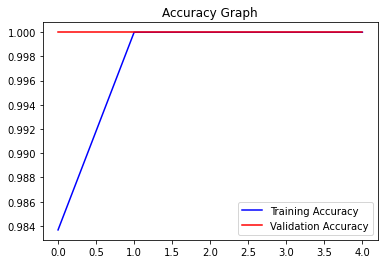

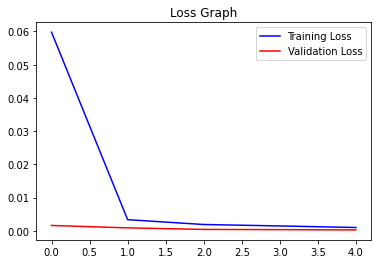

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

#Function for loading the saved model

In [ ]:
def load_model():
  model=tf.keras.models.load_model('/content/drive/MyDrive/GiantPlateletClassifier2.hdf5')
  return model

In [ ]:
model=load_model()

In [ ]:
import numpy as np
import glob,cv2
arr=[]
test_dir=r"/content/drive/MyDrive/test"
for img in glob.glob(test_dir+"/*"):
    images= cv2.imread(img)
    images=cv2.resize(images, (224,224), interpolation = cv2.INTER_AREA)
    img_pred=np.array(images)
    img_pred=np.expand_dims(img_pred,axis=0)
    result=model.predict(img_pred)
    if result[0][0]>result[0][1]:
      arr.append(1)
    else:
      arr.append(0)
np_array=np.array(arr)

#Creating Confusion Matrix

              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.92      0.85      0.88        13

    accuracy                           0.88        24
   macro avg       0.88      0.88      0.87        24
weighted avg       0.88      0.88      0.88        24



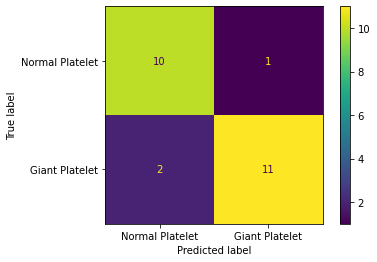

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
cm = confusion_matrix(test_label, np_array)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Normal Platelet','Giant Platelet'])
cmd.plot()
print(classification_report(test_label, np_array))

In [ ]:
!pip install gradio

In [ ]:
from keras.preprocessing import image
import numpy as np
import torch
import gradio as gr
def classify(Image):
  img_pred=np.array(Image)
  img_pred=np.expand_dims(img_pred,axis=0)
  result=model.predict(img_pred)
  if result[0][0]>result[0][1]:
    predic="Giant Platelet"
  else:
    predic="Normal Platelet"
  return predic
image=gr.inputs.Image(shape=(224,224))
gr.Interface(fn=classify,inputs=image,outputs="text",capture_session=True,title="GIANT PLATELET DETECTOR",
             theme="peach",
             css="body{text-align:center}body description{color:black}").launch(debug='True')
